# Image Classification using ResNet



Introduction

Install keras and other relevant packages

In [ ]:
from keras import backend as K
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input
from PIL import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint

Connecting google drive to access files.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# this creates a symbolic link so that now the path /content/drive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': File exists


Importing input data 

In [ ]:
#main dataset
data = np.load("/mydrive/Image_classification/data/input_data.npz")


In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = data['a'], data['b'], data['c'], data['d'],data['e'],data['f']

View some of the data images

prey
prey
prey
nonprey
nonprey


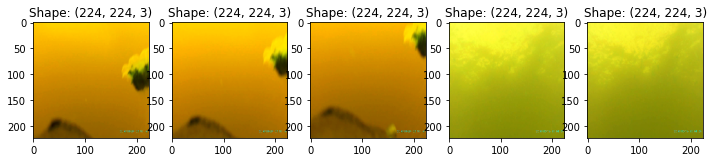

In [ ]:
sample_num = 5
fig = plt.figure(figsize=(12, 12))
for i,v in enumerate(range(2379,2384)):
  fig.add_subplot(1, sample_num, i+1).title.set_text(f'Shape: {x_train[v].shape}')
  plt.imshow(x_train[v])
  print(y_train[v])

In [ ]:
#Checking the file shapes

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(4693, 224, 224, 3)
(4693,)
(908, 224, 224, 3)
(908,)
(1133, 224, 224, 3)
(1133,)


In [ ]:
#Checking target label
print(y_train[4212])

nonprey


In [ ]:
#Checking structure of input data
print(x_train[0])

In [ ]:
#preprocessing the input data
x_train = preprocess_input(x_train)
x_valid = preprocess_input(x_valid )
x_test = preprocess_input(x_test)

In [ ]:
print(x_train.shape, x_valid.shape, x_test.shape,)

(4693, 224, 224, 3) (908, 224, 224, 3) (1133, 224, 224, 3)


In [ ]:
#one hot encoding the target variable for the training set
vocab, inv = np.unique(y_train, return_inverse=True)
y_train = to_categorical(inv)

In [ ]:
#one hot encoding the target variable for the validation set
vocab, inv = np.unique(y_valid, return_inverse=True)
y_valid = to_categorical(inv)

In [ ]:
#one hot encoding the target variable for the test set
vocab, inv = np.unique(y_test, return_inverse=True)
y_test = to_categorical(inv)

In [ ]:
print(y_train.shape, y_valid.shape, y_test.shape)

(4693, 2) (908, 2) (1133, 2)


In [ ]:
#Importing model architecture from the hyperparameter tuning
model = tf.keras.models.load_model("/mydrive/Image_classification/models/best_two_layer_model.h5")

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

Import weights from best performing epoch with a validation accuracy of 0.9020

In [ ]:
model.load_weights('/mydrive/Image_classification/models/training/model1.10-0.90.h5')

Evaluate model on Validation Data

In [ ]:
scores = model.evaluate(x_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 90.20%


In [ ]:
valid_pred = model.predict(x_valid)
val_pred_classes = np.argmax(valid_pred,axis=1)

In [ ]:
correct_values = np.argmax(y_valid,axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
accuracy_score(val_pred_classes,correct_values)*100

90.19823788546255

In [ ]:
confusion_matrix(val_pred_classes, correct_values)

array([[368,  26],
       [ 63, 451]])

In [ ]:
def performance_measures(y_pred, y_true):
  """
  Outputs the and specificity of a binary classification prediction model
  Inputs:
    y_pred (list) - predictions from model  
    y_true (list) - true classes of dataset
  Output:
   recall, precision (tuple) - the recall, precision of the model
  """
  confusion = confusion_matrix(y_pred, y_true)
  TP = confusion[1,1]
  FN = confusion[0,1]
  FP = confusion[1,0]

  recall = TP/(TP+FN)
  precision = TP/(TP+FP)

  return recall, precision

In [ ]:
performance_measures(val_pred_classes,correct_values)

(0.9454926624737946, 0.877431906614786)

Evaluation on Test Set

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 92.23%


In [ ]:
test_pred = model.predict(x_test)
test_pred_classes = np.argmax(test_pred,axis=1)

In [ ]:
test_correct_values = np.argmax(y_test,axis=1)

In [ ]:
performance_measures(test_pred_classes,test_correct_values)

(0.9291338582677166, 0.9007633587786259)

In [ ]:
import pandas as pd
import datetime

In [ ]:
def plot_results(start_datetime, frame_rate, true, pred, filename):
  """
  Outputs and saves line graph of the true and predicted classes of images in a clip
  Inputs:
    start_datetime (str) - the start time of video clip used
    frame_rate (int) - the number of frames per second in the video clip the 
                        images were extracted from 
    pred (list) - predicted classes of dataset  
    true (list) - true classes of dataset
    filename (str) - path to location and file name of saved plot
  Output:
   visualization 
  """

  import datetime as dt
  import matplotlib.pyplot as plt
  %matplotlib inline

  start_datetime = pd.to_datetime(start_datetime)
  date = start_datetime.date()
  start_time = start_datetime.time()

  time = start_time
  time_label = [start_time]
  delta = dt.timedelta(seconds=(1/frame_rate))

  for i in range(0, (len(pred)-1)):
    time = (dt.datetime.combine(dt.date(1,1,1),time) + delta).time()
    time_label.append(time)
  
  time = start_time
  seconds = int(round(len(pred)/(frame_rate/2),0))
  time_ticks =[start_time]

  for i in range(0, (seconds)):
    time = (dt.datetime.combine(dt.date(1,1,1),time) +  dt.timedelta(seconds=(1/2))).time()
    time_ticks.append(str(time))
    
  df = pd.concat([pd.DataFrame({'time':time_label}).astype('str'),  pd.DataFrame({'prediction':pred}),  pd.DataFrame({'ground_truth':true})], axis=1)

  fig, ax = plt.subplots(figsize=(20, 10))
  plt.plot(df['time'],df['prediction'], 'r', label='predictions')
  plt.plot(df['time'],df['ground_truth'], 'b', label='ground truth')
  plt.xlabel('Time on ' + str(date))
  plt.xticks(np.arange(len(pred), step=(frame_rate/2)),time_ticks, fontsize=17)
  plt.yticks(fontsize=19)
  plt.legend()

  plt.ylabel('Prediction')
  ax.set_xlabel('Time on ' + str(date), fontsize=25)
  ax.set_ylabel('Prediction', fontsize=25)

  plt.savefig((filename+'.png'))
  plt.show()

## Semi Supervised Task

In [ ]:
#import extra data
tester = np.load("/mydrive/Image_classification/data/tester_clips.npz")
tester1 = np.load("/mydrive/Image_classification/data/tester_clips1.npz")


In [ ]:
vid_a = tester['a']
vid_b = tester['b']
vid_c = tester['c']
vid_d = tester1['a']

In [ ]:
#import extra data's information files
tester_df= pd.read_csv("/mydrive/Image_classification/data/tester_clips.csv")
tester1_df= pd.read_csv("/mydrive/Image_classification/data/tester_clips1.csv")
tester1_df.head()

,Unnamed: 0,File_Name,penguin_ID,Video_ID,Date,Time,Frame_No,Label
0,0,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13360,nonprey
1,1,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13361,nonprey
2,2,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13362,nonprey
3,3,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13363,nonprey
4,4,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13364,nonprey


In [ ]:
print(len(tester_df), len(vid_a), len(vid_b), len(vid_c))

144 41 51 52


In [ ]:
y_vid_a = tester_df['Label'][0:41]
y_vid_b = tester_df['Label'][41:92]
y_vid_c = tester_df['Label'][92:]
y_vid_d = tester1_df['Label']

In [ ]:
#Encoding the label 
vocab, inv = np.unique(y_vid_a, return_inverse=True)
y_vid_a = to_categorical(inv)
vocab, inv = np.unique(y_vid_b, return_inverse=True)
y_vid_b = to_categorical(inv)
vocab, inv = np.unique(y_vid_c, return_inverse=True)
y_vid_c = to_categorical(inv)
vocab, inv = np.unique(y_vid_d, return_inverse=True)
y_vid_d = to_categorical(inv)

In [ ]:
#preprocessing
vid_a = preprocess_input(vid_a)
vid_b = preprocess_input(vid_b)
vid_c = preprocess_input(vid_c)
vid_d = preprocess_input(vid_d)

Predicting Video 1 with three smaller sections

In [ ]:
vid_pred_a = model.predict(vid_a)
vid_pred_b = model.predict(vid_b)
vid_pred_c = model.predict(vid_c)

In [ ]:
vida_pred_classes = np.argmax(vid_pred_a,axis=1)
vidb_pred_classes = np.argmax(vid_pred_b,axis=1)
vidc_pred_classes = np.argmax(vid_pred_c,axis=1)

In [ ]:
vid1_pred_classes = np.concatenate((vida_pred_classes, vidb_pred_classes,vidc_pred_classes))
vid1_pred_classes.shape

(144,)

In [ ]:
vid1_prob = np.concatenate((vid_pred_a, vid_pred_b,vid_pred_c))
vid1_prob.shape

(144, 2)

In [ ]:
print(vid1_prob[0:,1])

[1.1025738e-01 1.1025738e-01 2.0786089e-01 2.1130955e-01 1.1025738e-01
 1.1025738e-01 1.1025738e-01 1.1025738e-01 5.3028458e-01 4.6355972e-01
 7.3942655e-01 7.5769341e-01 1.1025738e-01 2.2906557e-01 2.0385075e-01
 8.8389677e-01 9.3235099e-01 8.4235626e-01 1.1025738e-01 9.4367337e-01
 3.4157792e-01 2.0493069e-01 4.6916759e-01 8.3233595e-01 9.6428299e-01
 4.6455613e-01 7.6168537e-01 9.7889233e-01 8.0707729e-01 1.1299980e-01
 8.5381389e-01 4.1159138e-01 5.4524034e-01 3.2756174e-01 1.1025738e-01
 2.2481512e-01 2.3162526e-01 4.4617471e-01 1.1986932e-01 9.2970538e-01
 1.1025738e-01 1.1025738e-01 6.5934420e-01 5.8003497e-01 1.1025738e-01
 9.9998319e-01 1.1025738e-01 9.6712577e-01 8.3012104e-01 2.5013962e-01
 5.3008449e-01 1.1025738e-01 1.1025738e-01 3.2455373e-01 1.1025738e-01
 1.1025738e-01 1.1025738e-01 1.1025738e-01 2.4191213e-01 3.1371689e-01
 2.9123762e-01 2.5237590e-01 1.1025738e-01 2.6015243e-01 2.5331664e-01
 1.1025738e-01 1.1025738e-01 1.1025738e-01 1.1025738e-01 1.1025738e-01
 1.102

In [ ]:
correct_val_a = np.argmax(y_vid_a,axis=1)
correct_val_b = np.argmax(y_vid_b,axis=1)
correct_val_c = np.argmax(y_vid_c,axis=1)

In [ ]:
correct_val_vid1 = np.concatenate((correct_val_a, correct_val_b,correct_val_c))
correct_val_vid1.shape

(144,)

In [ ]:
location = "/mydrive/Image_classification/results/image_outputs/"

In [ ]:
accuracy_score(vida_pred_classes,correct_val_a)*100

73.17073170731707

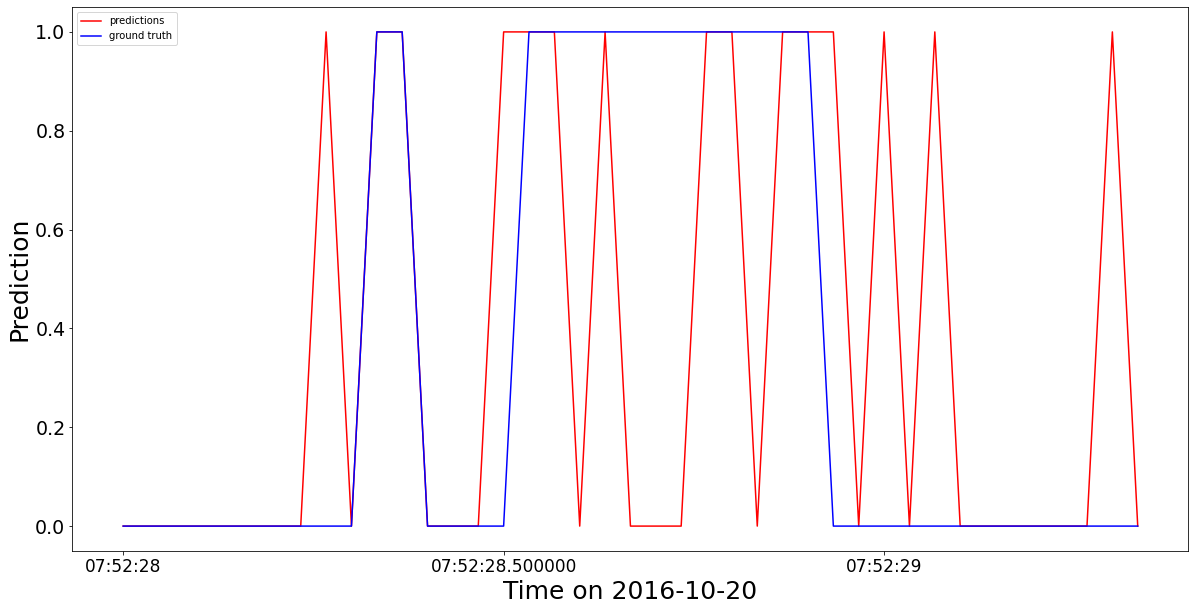

In [ ]:
#Plotting predictions against ground truth labels
plot_results('2016-10-20 07:52:28', frame_rate = 30, true= correct_val_a, pred = vida_pred_classes, filename = (location+"clip_a_1"))

In [ ]:
accuracy_score(vidb_pred_classes,correct_val_b)*100

49.01960784313725

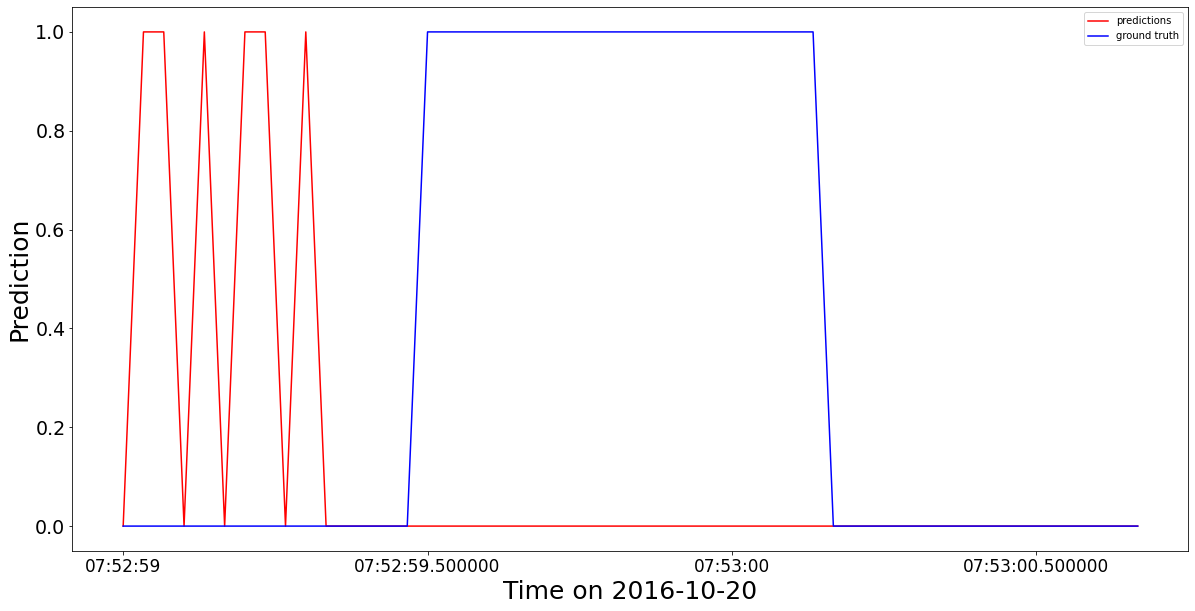

In [ ]:
plot_results('2016-10-20 07:52:59', frame_rate = 30, true= correct_val_b, pred = vidb_pred_classes, filename = (location+"clip_b_1"))

In [ ]:
accuracy_score(vidc_pred_classes,correct_val_c)*100

73.07692307692307

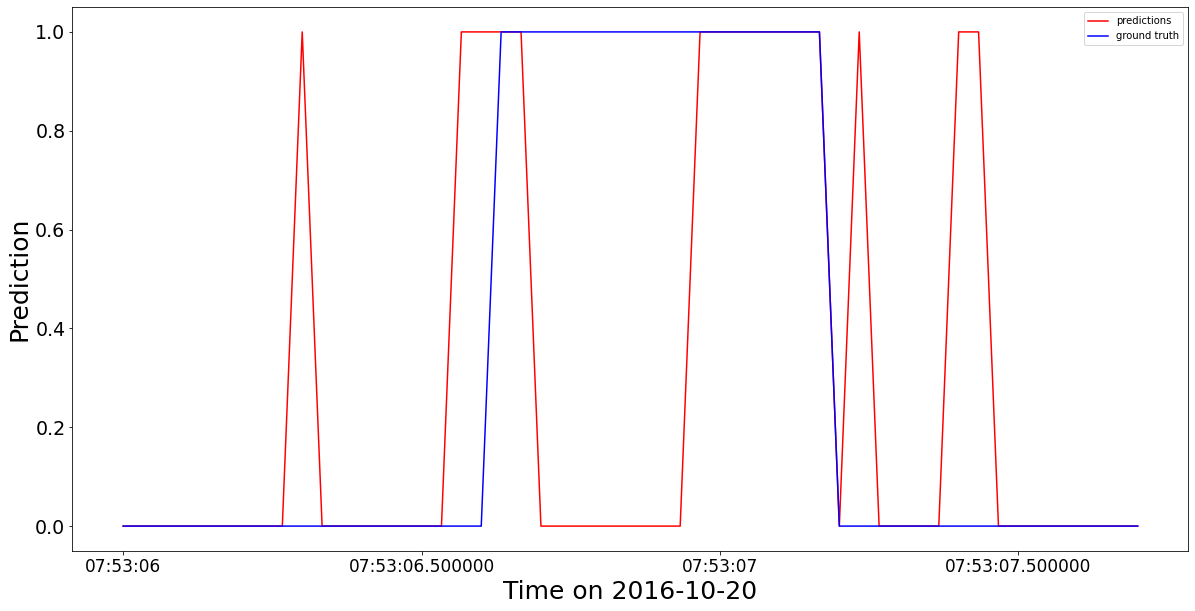

In [ ]:
plot_results('2016-10-20 07:53:06', frame_rate = 30, true= correct_val_c, pred = vidc_pred_classes, filename = (location+"clip_c_1"))

In [ ]:
tester_df["Correct_Label"] =  correct_val_vid1
tester_df["Predicted_Label"] =  vid1_pred_classes
tester_df["Probability"] = vid1_prob[0:,1]
tester_df.head()

,Unnamed: 0,File_Name,penguin_ID,Video_ID,Date,Time,Frame_No,Label,Correct_Label,Predicted_Label,Probability
0,0,GI-LP0238_7_MOVI0006.avi_image_2016-10-20_07_5...,GI-LP0238,MOVI0006,2016-10-20,07:52:28,4200,nonprey,0,0,0.110257
1,1,GI-LP0238_7_MOVI0006.avi_image_2016-10-20_07_5...,GI-LP0238,MOVI0006,2016-10-20,07:52:28,4201,nonprey,0,0,0.110257
2,2,GI-LP0238_7_MOVI0006.avi_image_2016-10-20_07_5...,GI-LP0238,MOVI0006,2016-10-20,07:52:28,4202,nonprey,0,0,0.207861
3,3,GI-LP0238_7_MOVI0006.avi_image_2016-10-20_07_5...,GI-LP0238,MOVI0006,2016-10-20,07:52:28,4203,nonprey,0,0,0.211310
4,4,GI-LP0238_7_MOVI0006.avi_image_2016-10-20_07_5...,GI-LP0238,MOVI0006,2016-10-20,07:52:28,4204,nonprey,0,0,0.110257


In [ ]:
tester_df.to_csv("/mydrive/Image_classification/results/tester_with_pred.csv")

In [ ]:
#Extracting misclassified images
vid_a_extract = vid_a[vida_pred_classes != correct_val_a]
vid_b_extract = vid_b[vidb_pred_classes != correct_val_b]
vid_c_extract = vid_c[vidc_pred_classes != correct_val_c]

In [ ]:
#corresponding y labels to misclassified images
vid_a_y_extract = y_vid_a[vida_pred_classes != correct_val_a]
vid_b_y_extract = y_vid_b[vidb_pred_classes != correct_val_b]
vid_c_y_extract = y_vid_c[vidc_pred_classes != correct_val_c]

In [ ]:
additional_dataX = np.concatenate((vid_a_extract,vid_b_extract, vid_c_extract))
additional_dataY = np.concatenate((vid_a_y_extract, vid_b_y_extract, vid_c_y_extract))

In [ ]:
#combining misclassified data to training set
new_x_train = np.concatenate((x_train, additional_dataX))
new_y_train = np.concatenate((y_train, additional_dataY))

Saving the joined dataset for use in the event that Colab exhausts RAM 

In [ ]:
np.savez("/mydrive/Image_classification/data/new_train_data.npz", x=new_x_train, y=new_y_train)

In [ ]:
training = np.load("/mydrive/Image_classification/data/new_train_data.npz")
new_x_train = training['x']
new_y_train = training['y']

Retraining the model with the additional data

In [ ]:
my_callbacks = [
    EarlyStopping('val_loss', patience=5),
    ModelCheckpoint(
        filepath='/mydrive/Image_classification/models/semi1/model.{epoch:02d}-{val_accuracy:.2f}.h5'),
]

In [ ]:
        #uncomment to reload model architecture and weights if notebook is restarted

#model = tf.keras.models.load_model("/mydrive/Image_classification/models/best_two_layer_model.h5")
#model.load_weights('/mydrive/Image_classification/models/training/model1.10-0.90.h5')

In [ ]:
#Fit the model again
model.fit(new_x_train, new_y_train, epochs = 50, validation_data = (x_valid, y_valid), callbacks=my_callbacks)

Epoch 1/50
149/149 [==============================] - 20s 133ms/step - loss: 0.2317 - accuracy: 0.9309 - val_loss: 0.5356 - val_accuracy: 0.8667
Epoch 2/50
149/149 [==============================] - 20s 133ms/step - loss: 0.2601 - accuracy: 0.9233 - val_loss: 0.4092 - val_accuracy: 0.8910
Epoch 3/50
149/149 [==============================] - 20s 135ms/step - loss: 0.2721 - accuracy: 0.9178 - val_loss: 1.1562 - val_accuracy: 0.8811
Epoch 4/50
149/149 [==============================] - 19s 129ms/step - loss: 0.2829 - accuracy: 0.9056 - val_loss: 0.5114 - val_accuracy: 0.8568
Epoch 5/50
149/149 [==============================] - 19s 128ms/step - loss: 0.2424 - accuracy: 0.9222 - val_loss: 0.2902 - val_accuracy: 0.9108
Epoch 6/50
149/149 [==============================] - 20s 131ms/step - loss: 0.3441 - accuracy: 0.8931 - val_loss: 0.6514 - val_accuracy: 0.8877
Epoch 7/50
149/149 [==============================] - 20s 132ms/step - loss: 0.3054 - accuracy: 0.8971 - val_loss: 0.6353 - val_ac

In [ ]:
#Load weights after retraining model
model.load_weights('/mydrive/Image_classification/models/semi1/model.05-0.91.h5')

In [ ]:
#validation set predictions
valid_pred = model.predict(x_valid)
val_pred_classes = np.argmax(valid_pred,axis=1)

In [ ]:
accuracy_score(val_pred_classes,correct_values)*100

91.07929515418502

In [ ]:
con_matrix = confusion_matrix(val_pred_classes,correct_values)
con_matrix

array([[391,  41],
       [ 40, 436]])

In [ ]:
recall, precision = performance_measures(val_pred_classes, correct_values)
print(recall, precision)

0.9140461215932913 0.9159663865546218


In [ ]:
f1_score = 2*precision*recall/(precision+recall)
f1_score

0.9150052465897167

Predicting on Video 2

In [ ]:
vid_pred_d = model.predict(vid_d)

In [ ]:
vidd_pred_classes = np.argmax(vid_pred_d,axis=1)

In [ ]:
correct_val_d = np.argmax(y_vid_d,axis=1)

In [ ]:
accuracy_score(vidd_pred_classes,correct_val_d)*100

51.35135135135135

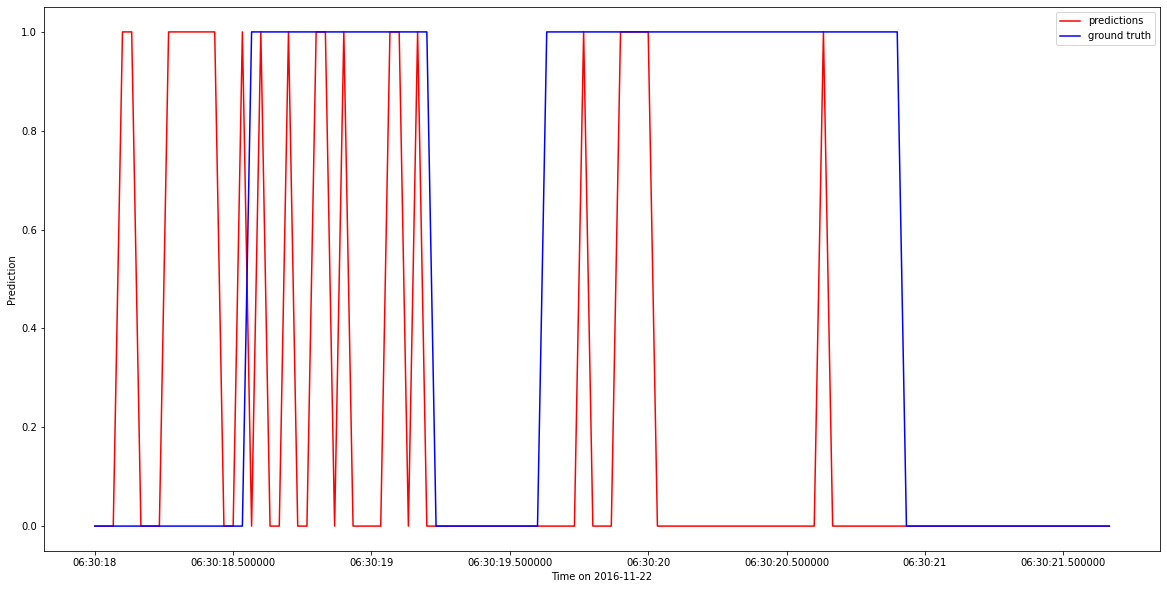

In [ ]:
plot_results('2016-11-22 06:30:18', frame_rate = 30, true= correct_val_d, pred = vidd_pred_classes, filename = (location+"clip_d"))

In [ ]:
vid_d_extract = vid_d[vidd_pred_classes != correct_val_d]
vid_d_y_extract = y_vid_d[vidd_pred_classes != correct_val_d]

In [ ]:
np.savez("/mydrive/Image_classification/data/incorrect_tester1_data.npz", x=vid_d_extract, y=vid_d_y_extract)

In [ ]:
tester1_df["Correct_Label"] =  correct_val_d
tester1_df["Predicted_Label"] =  vidd_pred_classes
tester1_df["Probability"] =  vid_pred_d[0:,1]
tester1_df.head()

,Unnamed: 0,File_Name,penguin_ID,Video_ID,Date,Time,Frame_No,Label,Correct_Label,Predicted_Label,Probability
0,0,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13360,nonprey,0,0,0.383883
1,1,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13361,nonprey,0,0,0.266371
2,2,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13362,nonprey,0,0,0.499876
3,3,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13363,nonprey,0,1,0.902275
4,4,GI-LP0262_5_MOVI0004.avi_image_2016-11-22_06_3...,GI-LP0262,MOVI0004,2016-11-22,06:30:18,13364,nonprey,0,1,0.544522


In [ ]:
tester1_df.to_csv("/mydrive/Image_classification/results/tester1_with_pred.csv")

In [ ]:
vidd_extract = np.load("/mydrive/Image_classification/data/incorrect_tester1_data.npz")
vid_d_extract = vidd_extract['x']
vid_d_y_extract = vidd_extract['y']

In [ ]:
new_x_train = np.concatenate((new_x_train, vid_d_extract))
new_y_train = np.concatenate((new_y_train, vid_d_y_extract))

In [ ]:
my_callbacks = [
    EarlyStopping('val_loss', patience=5),
    ModelCheckpoint(
        filepath='/mydrive/Image_classification/models/semi2/model.{epoch:02d}-{val_accuracy:.2f}.h5'),
]

In [ ]:
#Fit the model again
model.fit(new_x_train, new_y_train, epochs = 50, validation_data = (x_valid, y_valid), callbacks=my_callbacks)

Epoch 1/50
150/150 [==============================] - 20s 137ms/step - loss: 0.3216 - accuracy: 0.8881 - val_loss: 0.8276 - val_accuracy: 0.8469
Epoch 2/50
150/150 [==============================] - 20s 133ms/step - loss: 0.3483 - accuracy: 0.9023 - val_loss: 1.8230 - val_accuracy: 0.7632
Epoch 3/50
150/150 [==============================] - 20s 132ms/step - loss: 0.3158 - accuracy: 0.9108 - val_loss: 1.2547 - val_accuracy: 0.8381
Epoch 4/50
150/150 [==============================] - 22s 150ms/step - loss: 0.2727 - accuracy: 0.9077 - val_loss: 0.7620 - val_accuracy: 0.8304
Epoch 5/50
150/150 [==============================] - 19s 130ms/step - loss: 0.3247 - accuracy: 0.8754 - val_loss: 0.6196 - val_accuracy: 0.8469
Epoch 6/50
150/150 [==============================] - 20s 132ms/step - loss: 0.3527 - accuracy: 0.8789 - val_loss: 0.3969 - val_accuracy: 0.8337
Epoch 7/50
150/150 [==============================] - 19s 129ms/step - loss: 0.3549 - accuracy: 0.8668 - val_loss: 1.3668 - val_ac

No improvements in the accuracy of the model, so will use the weights from previous iteration

In [ ]:
model.load_weights('/mydrive/Image_classification/models/semi1/model.05-0.91.h5')

In [ ]:
scores = model.evaluate(x_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 91.08%


In [ ]:
valid_pred = model.predict(x_valid)
val_pred_classes = np.argmax(valid_pred,axis=1)

In [ ]:
performance_measures(val_pred_classes,correct_values)

(0.9140461215932913, 0.9159663865546218)

In [ ]:
sum(correct_values)

477

In [ ]:
con_matrix = confusion_matrix(val_pred_classes,correct_values)
con_matrix

array([[391,  41],
       [ 40, 436]])

## Final Prediction on Test Set

Fit for the test set

In [ ]:
new_x_train = np.concatenate((new_x_train, x_valid))
new_y_train = np.concatenate((new_y_train, y_valid))

In [ ]:
#Fit the model again
model.fit(new_x_train, new_y_train)

179/179 [==============================] - 18s 98ms/step - loss: 0.4008 - accuracy: 0.8864


In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 89.94%


In [ ]:
test_pred = model.predict(x_test)
test_pred_classes = np.argmax(test_pred,axis=1)

In [ ]:
correct_test_values = np.argmax(y_test,axis=1)

In [ ]:
con_matrix = confusion_matrix(test_pred_classes,correct_test_values)
con_matrix

array([[581,  67],
       [ 44, 441]])

In [ ]:
import seaborn as sns
sns.heatmap(con_matrix, annot=True, fmt=' ', cmap='Blues')

In [ ]:
recall, precision =performance_measures(test_pred_classes,correct_test_values)
recall, precision

(0.8681102362204725, 0.9092783505154639)

In [ ]:
Data_file = pd.read_csv("/mydrive/Image_classification/data/Data_file.csv")

In [ ]:
np.unique(Data_file['split'])

array(['test', 'train', 'validation'], dtype=object)

In [ ]:
Data_file[Data_file['split']=='test'].head()

,Unnamed: 0,penguin_ID,Video_ID,Date,Time,Frame_No,Label,File_Name,split
751,751,GI-LP0238,MOVI0001,2016-10-20,05:42:11,24848,prey,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,test
752,752,GI-LP0238,MOVI0001,2016-10-20,05:42:11,24849,prey,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,test
753,753,GI-LP0238,MOVI0001,2016-10-20,05:42:11,24850,prey,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,test
754,754,GI-LP0238,MOVI0001,2016-10-20,05:42:11,24851,prey,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,test
755,755,GI-LP0238,MOVI0001,2016-10-20,05:42:11,24852,prey,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,test


In [ ]:
test_file = Data_file[Data_file['split']=='test'][['File_Name','Label']]
test_file["Correct_Label"] =  correct_test_values
test_file["Predicted_Label"] =  test_pred_classes
test_file.head()

,File_Name,Label,Correct_Label,Predicted_Label
751,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0
752,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0
753,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0
754,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0
755,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0


In [ ]:
wrong_predictions = test_file[test_file["Correct_Label"] != test_file["Predicted_Label"]]
wrong_predictions.head()

,File_Name,Label,Correct_Label,Predicted_Label
751,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0
752,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0
753,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0
754,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0
755,GI-LP0238_2_MOVI0001.avi_image_2016-10-20_05_4...,prey,1,0


In [ ]:
wrong_predictions.to_csv("/mydrive/Image_classification/results/wrong_predictions_test.csv")